In [ ]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta


from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [51]:
df = pd.read_csv('project_dataset.csv')

In [52]:
df.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,0,1.0,24924.50,42.31,2.572,211.096358,8.106
1,2010-02-05,0,26.0,11737.12,42.31,2.572,211.096358,8.106
2,2010-02-05,0,17.0,13223.76,42.31,2.572,211.096358,8.106
3,2010-02-05,0,45.0,37.44,42.31,2.572,211.096358,8.106
4,2010-02-05,0,28.0,1085.29,42.31,2.572,211.096358,8.106


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10244 entries, 0 to 10243
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          10244 non-null  object 
 1   IsHoliday     10244 non-null  int64  
 2   Dept          10244 non-null  float64
 3   Weekly_Sales  10244 non-null  float64
 4   Temperature   10244 non-null  float64
 5   Fuel_Price    10244 non-null  float64
 6   CPI           10244 non-null  float64
 7   Unemployment  10244 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 640.4+ KB


In [61]:
df = df[df['Dept'] == 2]
df.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
22,2010-02-05,0,2.0,50605.27,42.31,2.572,211.096358,8.106
133,2010-02-12,1,2.0,44682.74,38.51,2.548,211.242170,8.106
186,2010-02-19,0,2.0,47928.89,39.93,2.514,211.289143,8.106
241,2010-02-26,0,2.0,44292.87,46.63,2.561,211.319643,8.106
321,2010-03-05,0,2.0,48397.98,46.50,2.625,211.350143,8.106


In [62]:
df.shape

(143, 8)

In [63]:
df['Dept'].nunique()

1

In [64]:
mapping = {0: False, 1: True}
df['IsHoliday'] = df['IsHoliday'].map(mapping)

```I will have a look at the dataset  to see if there is any weird values or not.```

In [65]:
df.describe()

,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,143.0,143.000000,143.000000,143.000000,143.000000,143.000000
mean,2.0,46102.090420,68.306783,3.219699,215.996892,7.610420
std,0.0,3440.673222,14.250486,0.427313,4.350890,0.383749
min,2.0,35819.830000,35.400000,2.514000,210.337426,6.573000
25%,2.0,44170.460000,58.265000,2.764500,211.549277,7.348000
50%,2.0,45561.850000,69.640000,3.290000,215.459905,7.787000
75%,2.0,47612.245000,80.485000,3.594000,220.531330,7.838000
max,2.0,65615.360000,91.650000,3.907000,223.444251,8.106000


```It's clear there are incorrect values in the weekly sales data, specifically zeros and negative numbers. Sales figures can't be negative.```

In [66]:
# df.loc[df['Weekly_Sales']<=0]

In [67]:
# df = df.loc[df['Weekly_Sales'] > 0]
# df.shape

``` Great! there's no null values ```

In [68]:
df.isnull().sum()

Date            0
IsHoliday       0
Dept            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [69]:
df['Date'].head(5) # to see first 5 rows.

22     2010-02-05
133    2010-02-12
186    2010-02-19
241    2010-02-26
321    2010-03-05
Name: Date, dtype: object

In [70]:
df['Date'].tail(5) # to see last 5 rows.

9921     2012-09-28
10002    2012-10-05
10062    2012-10-12
10103    2012-10-19
10176    2012-10-26
Name: Date, dtype: object

``` So our data range is from 5th of February 2010 to 26th of October 2012.```

``` Investegating IsHoliday column, we could be able to derive some insights from it  ```

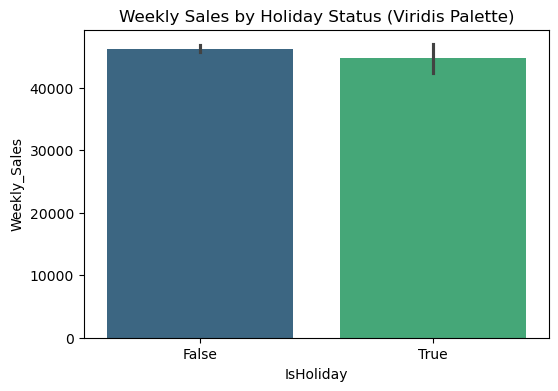

In [71]:
plt.figure(figsize=(6, 4))
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df, palette='viridis')
plt.title('Weekly Sales by Holiday Status (Viridis Palette)')
plt.show()

In [72]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

Missing Holiday Data
--------------------

Your dataset doesn't contain all the holiday information. We've identified four key holidays and their dates for 2010 through 2013:

-   **Super Bowl:** February 12, 2010; February 11, 2011; February 10, 2012; February 8, 2013
-   **Labor Day:** September 10, 2010; September 9, 2011; September 7, 2012; September 6, 2013
-   **Thanksgiving:** November 26, 2010; November 25, 2011; November 23, 2012; November 29, 2013
-   **Christmas:** December 31, 2010; December 30, 2011; December 28, 2012; December 27, 2013

In [77]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [78]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [79]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [80]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

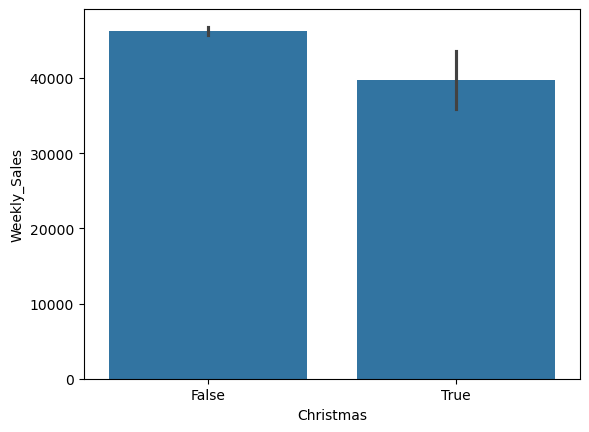

In [81]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) # Christmas holiday vs not-Christmas

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

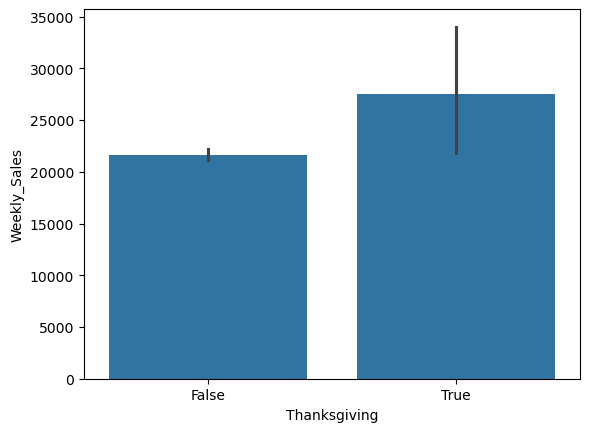

In [43]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) # Thanksgiving holiday vs not-thanksgiving

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

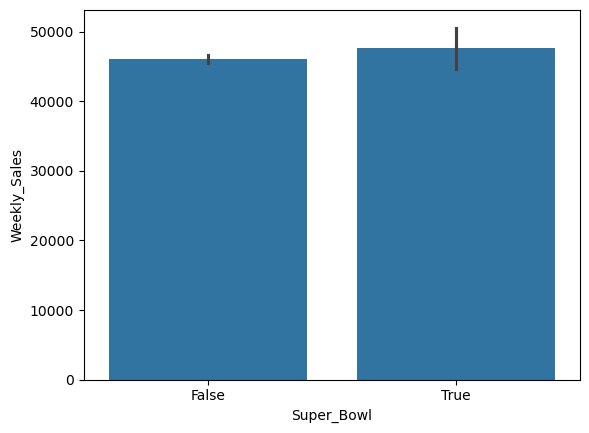

In [82]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) # Super bowl holiday vs not-super bowl

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

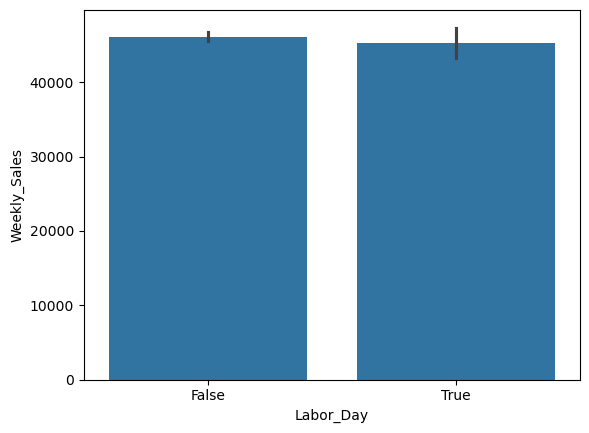

In [83]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) # Labor day holiday vs not-labor day

Analysis of Weekly Sales by Holiday

The data indicates that **Labor Day and Christmas do not significantly boost average weekly sales**. While **Super Bowl has a positive impact**, the **most substantial increase in sales occurs during Thanksgiving week**. This could be because consumers tend to purchase Christmas gifts in the weeks leading up to the holiday, rather than during Christmas week itself. The surge in Thanksgiving sales is likely attributed to **Black Friday promotions**.

In [84]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas
7076,2011-12-23,False,2.0,65615.36,47.96,3.112,219.357722,7.866,False,False,False,False
3341,2010-12-24,False,2.0,59889.32,52.33,2.886,211.405122,7.838,False,False,False,False
7472,2012-02-03,False,2.0,54322.24,56.55,3.360,220.172015,7.348,False,False,False,False
4069,2011-03-04,False,2.0,53035.54,59.58,3.288,213.823333,7.742,False,False,False,False
7814,2012-03-02,False,2.0,52608.51,60.96,3.630,220.848045,7.348,False,False,False,False


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 22 to 10176
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   IsHoliday     143 non-null    bool   
 2   Dept          143 non-null    float64
 3   Weekly_Sales  143 non-null    float64
 4   Temperature   143 non-null    float64
 5   Fuel_Price    143 non-null    float64
 6   CPI           143 non-null    float64
 7   Unemployment  143 non-null    float64
 8   Super_Bowl    143 non-null    object 
 9   Labor_Day     143 non-null    object 
 10  Thanksgiving  143 non-null    object 
 11  Christmas     143 non-null    object 
dtypes: bool(1), float64(6), object(5)
memory usage: 13.5+ KB


# Changing Date to Datetime and Creating New Columns

In [ ]:
# Convert 'Date' column to datetime objects
df["Date"] = pd.to_datetime(df["Date"])

# Corrected way to get week, month, and year

# For week number (ISO standard week)
df['week'] = df['Date'].dt.isocalendar().week.astype(int) # .astype(int) to get integer type

# For month
df['month'] = df['Date'].dt.month

# For year
df['year'] = df['Date'].dt.year

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 22 to 10176
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   IsHoliday     143 non-null    bool          
 2   Dept          143 non-null    float64       
 3   Weekly_Sales  143 non-null    float64       
 4   Temperature   143 non-null    float64       
 5   Fuel_Price    143 non-null    float64       
 6   CPI           143 non-null    float64       
 7   Unemployment  143 non-null    float64       
 8   Super_Bowl    143 non-null    object        
 9   Labor_Day     143 non-null    object        
 10  Thanksgiving  143 non-null    object        
 11  Christmas     143 non-null    object        
 12  week          143 non-null    int32         
 13  month         143 non-null    int32         
 14  year          143 non-null    int32         
dtypes: bool(1), datetime64[ns](1), float64(6),

In [89]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     42431.477500
2     47947.536667
3     46809.176154
4     46172.491429
5     45979.411667
6     46334.059231
7     45321.640000
8     47854.676923
9     45204.323846
10    44255.126923
11    44651.076250
12    49195.156000
Name: Weekly_Sales, dtype: float64

In [90]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    45844.475833
2011    45950.409423
2012    46573.088372
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

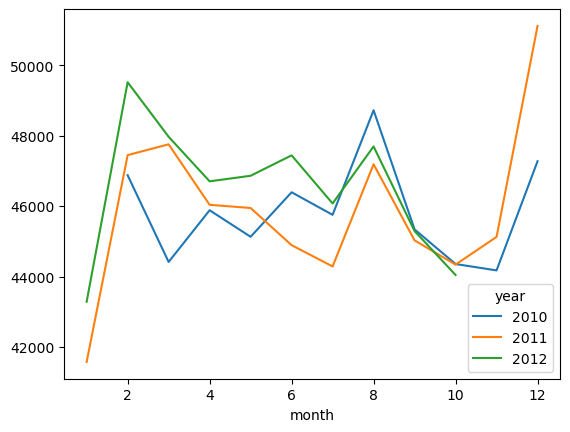

In [91]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

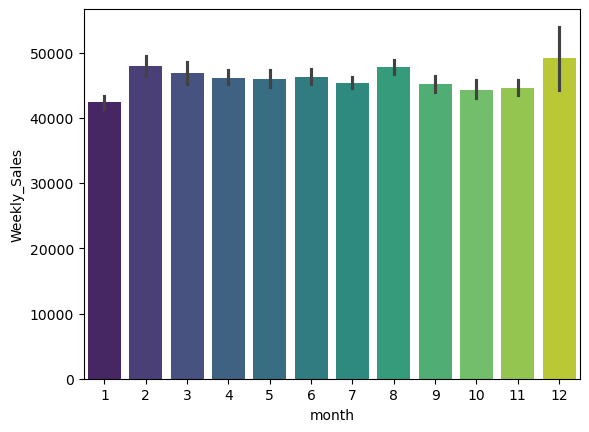

In [93]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df, palette='viridis')

* * * * *

Looking at the graph, **December and November** have the best sales, which makes sense. Even though Thanksgiving week has the absolute highest sales numbers and maybe also for the reason end of the year sales and black friday and so on, **December actually wins when you look at the average sales**.

In [94]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    62752.340000
9     51347.343333
5     50585.543333
50    50220.350000
35    49810.100000
Name: Weekly_Sales, dtype: float64

"The five best average sales weeks are the couple of weeks before Christmas, Thanksgiving, Black Friday, and the end of May (when schools close)."

<Axes: xlabel='week'>

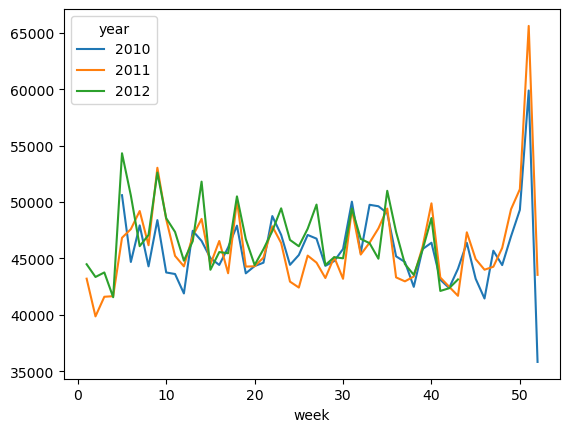

In [95]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

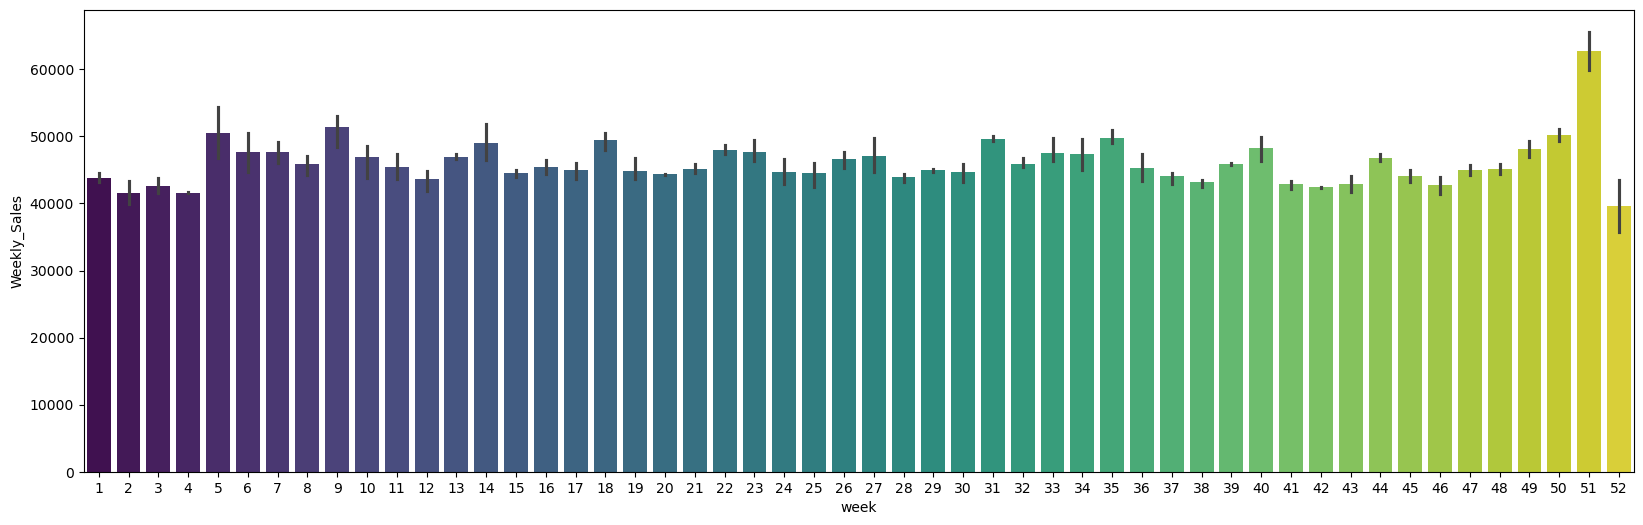

In [97]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df, palette = 'viridis')

```From graphs, it is seen that 51th week has significantly higher average as Christmas, Thankgiving and Black Friday effects.```

# Fuel Price, CPI , Unemployment , Temperature Effects

<Axes: xlabel='Fuel_Price'>

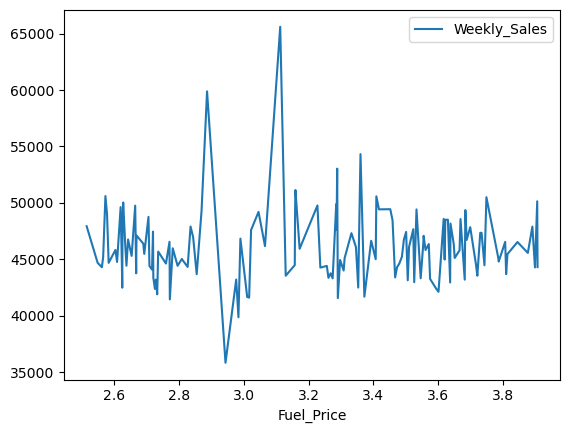

In [99]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<Axes: xlabel='Temperature'>

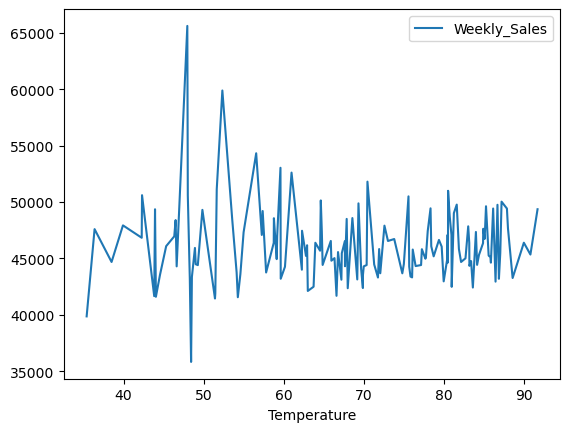

In [100]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<Axes: xlabel='CPI'>

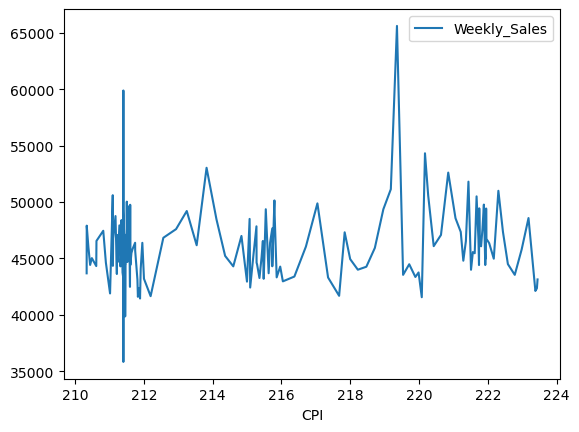

In [101]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<Axes: xlabel='Unemployment'>

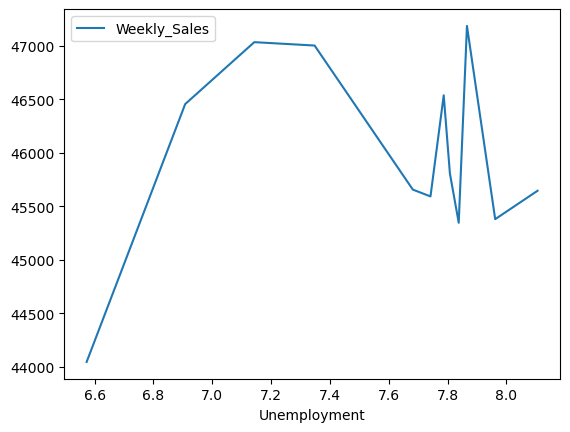

In [102]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

"The graphs don't show clear connections between weekly sales and things like prices (CPI), temperature, unemployment, or fuel cost."

# First try with Random Forest

In [103]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here

In [187]:
df = pd.read_csv('clean_data.csv')

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    143 non-null    int64  
 1   Date          143 non-null    object 
 2   IsHoliday     143 non-null    bool   
 3   Dept          143 non-null    float64
 4   Weekly_Sales  143 non-null    float64
 5   Temperature   143 non-null    float64
 6   Fuel_Price    143 non-null    float64
 7   CPI           143 non-null    float64
 8   Unemployment  143 non-null    float64
 9   Super_Bowl    143 non-null    bool   
 10  Labor_Day     143 non-null    bool   
 11  Thanksgiving  143 non-null    bool   
 12  Christmas     143 non-null    bool   
 13  week          143 non-null    int64  
 14  month         143 non-null    int64  
 15  year          143 non-null    int64  
dtypes: bool(5), float64(6), int64(4), object(1)
memory usage: 13.1+ KB


In [189]:
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    143 non-null    int64         
 1   Date          143 non-null    datetime64[ns]
 2   IsHoliday     143 non-null    bool          
 3   Dept          143 non-null    float64       
 4   Weekly_Sales  143 non-null    float64       
 5   Temperature   143 non-null    float64       
 6   Fuel_Price    143 non-null    float64       
 7   CPI           143 non-null    float64       
 8   Unemployment  143 non-null    float64       
 9   Super_Bowl    143 non-null    bool          
 10  Labor_Day     143 non-null    bool          
 11  Thanksgiving  143 non-null    bool          
 12  Christmas     143 non-null    bool          
 13  week          143 non-null    int64         
 14  month         143 non-null    int64         
 15  year          143 non-null    int64     

# Encoding the Data 

In [191]:
df_encoded = df.copy() 

In [192]:
df_encoded.head()

,Unnamed: 0,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,22,2010-02-05,False,2.0,50605.27,42.31,2.572,211.096358,8.106,False,False,False,False,5,2,2010
1,133,2010-02-12,True,2.0,44682.74,38.51,2.548,211.242170,8.106,True,False,False,False,6,2,2010
2,186,2010-02-19,False,2.0,47928.89,39.93,2.514,211.289143,8.106,False,False,False,False,7,2,2010
3,241,2010-02-26,False,2.0,44292.87,46.63,2.561,211.319643,8.106,False,False,False,False,8,2,2010
4,321,2010-03-05,False,2.0,48397.98,46.50,2.625,211.350143,8.106,False,False,False,False,9,3,2010


In [193]:
df_encoded.drop(columns=['Unnamed: 0'],inplace=True)

In [194]:
df_encoded.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,2010-02-05,False,2.0,50605.27,42.31,2.572,211.096358,8.106,False,False,False,False,5,2,2010
1,2010-02-12,True,2.0,44682.74,38.51,2.548,211.242170,8.106,True,False,False,False,6,2,2010
2,2010-02-19,False,2.0,47928.89,39.93,2.514,211.289143,8.106,False,False,False,False,7,2,2010
3,2010-02-26,False,2.0,44292.87,46.63,2.561,211.319643,8.106,False,False,False,False,8,2,2010
4,2010-03-05,False,2.0,48397.98,46.50,2.625,211.350143,8.106,False,False,False,False,9,3,2010


In [195]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1


In [196]:
df_new = df_encoded.copy()

In [197]:
df_new.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,2010-02-05,0,2.0,50605.27,42.31,2.572,211.096358,8.106,0,0,0,0,5,2,2010
1,2010-02-12,1,2.0,44682.74,38.51,2.548,211.242170,8.106,1,0,0,0,6,2,2010
2,2010-02-19,0,2.0,47928.89,39.93,2.514,211.289143,8.106,0,0,0,0,7,2,2010
3,2010-02-26,0,2.0,44292.87,46.63,2.561,211.319643,8.106,0,0,0,0,8,2,2010
4,2010-03-05,0,2.0,48397.98,46.50,2.625,211.350143,8.106,0,0,0,0,9,3,2010


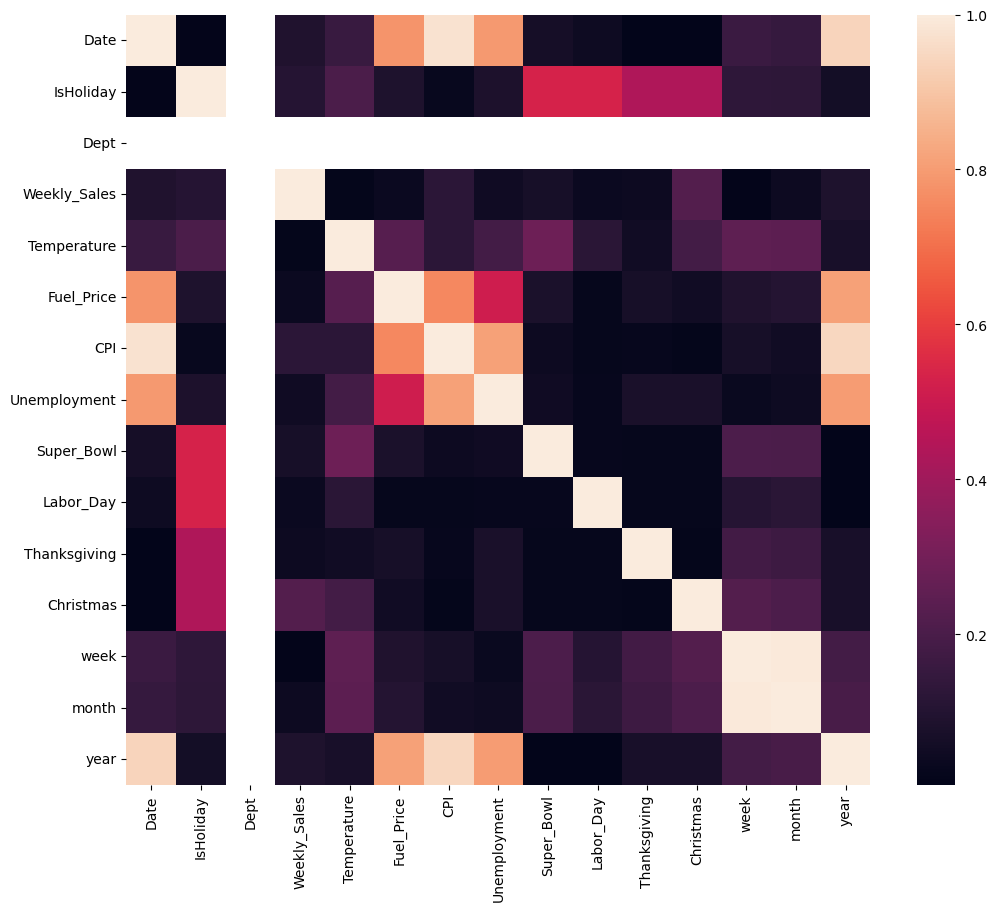

In [198]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations
plt.show()

Since temperature, unemployment, and CPI don't seem to significantly affect weekly sales, I'll remove these factors from our analysis.

In [199]:
drop_col = ['Temperature','Fuel_Price','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns
df_new.head()

,Date,IsHoliday,Dept,Weekly_Sales,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,2010-02-05,0,2.0,50605.27,0,0,0,0,5,2,2010
1,2010-02-12,1,2.0,44682.74,1,0,0,0,6,2,2010
2,2010-02-19,0,2.0,47928.89,0,0,0,0,7,2,2010
3,2010-02-26,0,2.0,44292.87,0,0,0,0,8,2,2010
4,2010-03-05,0,2.0,48397.98,0,0,0,0,9,3,2010


In [200]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

``` We have enough information in our date such as week of the year. So, I drop date columns.```

In [201]:
X = df_new[used_cols] # to keep train and test X values together
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

Our metric for this project is weighted mean absolute error (WMAE):

where

- n is the number of rows
- ŷ i is the predicted sales
- yi is the actual sales
- wi are weights. w = 5 if the week is a holiday week, 1 otherwise

With this metric, the error at holiday weeks has 5 times weight more than normal weeks. So, it is more important to predict sales at holiday weeks accurately.
All results for trails can be found at the end of this notebook.

![title](https://miro.medium.com/max/990/1*VKYKK85ViLYUUjyOWVURfw.jpeg)

In [202]:
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [203]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()



#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

In [204]:
wmae_test(y_test, y_pred_test)

2233.048734807766

In [205]:
import pickle

# Path where you want to save the model
model_path = "random_forest_pipeline.pkl"

# Save the pipeline model to disk
with open(model_path, "wb") as f:
    pickle.dump(pipe, f)

In [143]:
X = X.drop(['Date'], axis=1) #dropping date column from X

In [144]:
X.head()

,IsHoliday,Dept,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,0,2.0,0,0,0,0,5,2,2010
1,1,2.0,1,0,0,0,6,2,2010
2,0,2.0,0,0,0,0,7,2,2010
3,0,2.0,0,0,0,0,8,2,2010
4,0,2.0,0,0,0,0,9,3,2010


In [145]:
X.shape

(143, 9)

In [146]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   IsHoliday     143 non-null    int32         
 2   Dept          143 non-null    float64       
 3   Weekly_Sales  143 non-null    float64       
 4   Super_Bowl    143 non-null    int32         
 5   Labor_Day     143 non-null    int32         
 6   Thanksgiving  143 non-null    int32         
 7   Christmas     143 non-null    int32         
 8   week          143 non-null    int64         
 9   month         143 non-null    int64         
 10  year          143 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int32(5), int64(3)
memory usage: 9.6 KB


As we have seen before in the heatmap it showed that the months are correlated with weeks so I dropped month column and i'm going to use week column instead.

In [147]:
X1_train = X_train.drop(['month'], axis=1) # dropping month
X1_test = X_test.drop(['month'], axis=1)

In [148]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, y_train)

# predictions on train set
y_pred = pipe.predict(X1_train)

# predictions on test set
y_pred_test = pipe.predict(X1_test)

In [149]:
wmae_test(y_test, y_pred_test)

2295.3457341029593

# Time Series Models

In [155]:
df.head() # to see my data

,Unnamed: 0,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,22,2010-02-05,False,2.0,50605.27,42.31,2.572,211.096358,8.106,False,False,False,False,5,2,2010
1,133,2010-02-12,True,2.0,44682.74,38.51,2.548,211.242170,8.106,True,False,False,False,6,2,2010
2,186,2010-02-19,False,2.0,47928.89,39.93,2.514,211.289143,8.106,False,False,False,False,7,2,2010
3,241,2010-02-26,False,2.0,44292.87,46.63,2.561,211.319643,8.106,False,False,False,False,8,2,2010
4,321,2010-03-05,False,2.0,48397.98,46.50,2.625,211.350143,8.106,False,False,False,False,9,3,2010


In [156]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [157]:
df.set_index('Date', inplace=True) #seting date as index

In [158]:
df.head()

,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
Date,,,,,,,,,,,,,,
2010-02-05,False,2.0,50605.27,42.31,2.572,211.096358,8.106,False,False,False,False,5,2,2010
2010-02-12,True,2.0,44682.74,38.51,2.548,211.242170,8.106,True,False,False,False,6,2,2010
2010-02-19,False,2.0,47928.89,39.93,2.514,211.289143,8.106,False,False,False,False,7,2,2010
2010-02-26,False,2.0,44292.87,46.63,2.561,211.319643,8.106,False,False,False,False,8,2,2010
2010-03-05,False,2.0,48397.98,46.50,2.625,211.350143,8.106,False,False,False,False,9,3,2010


# Plotting Sales

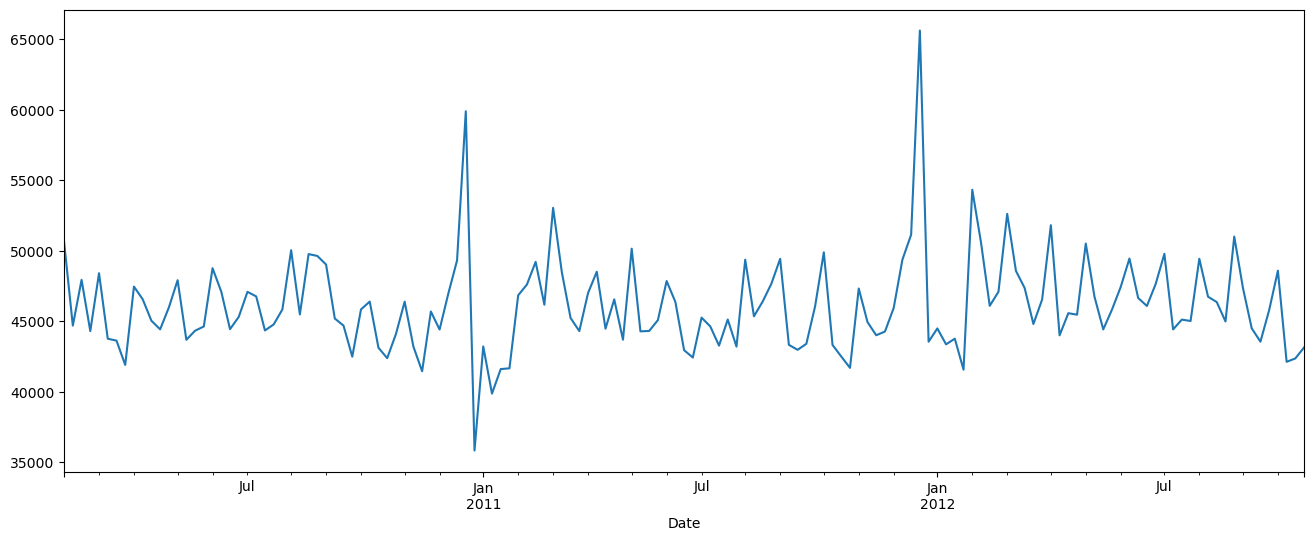

In [159]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

As we've seen, there's a **big jump in sales at the end of the year**, which is expected given the holidays and special offers we discussed earlier.

In [161]:
df_month = df.resample('MS').mean() # resampling as monthly

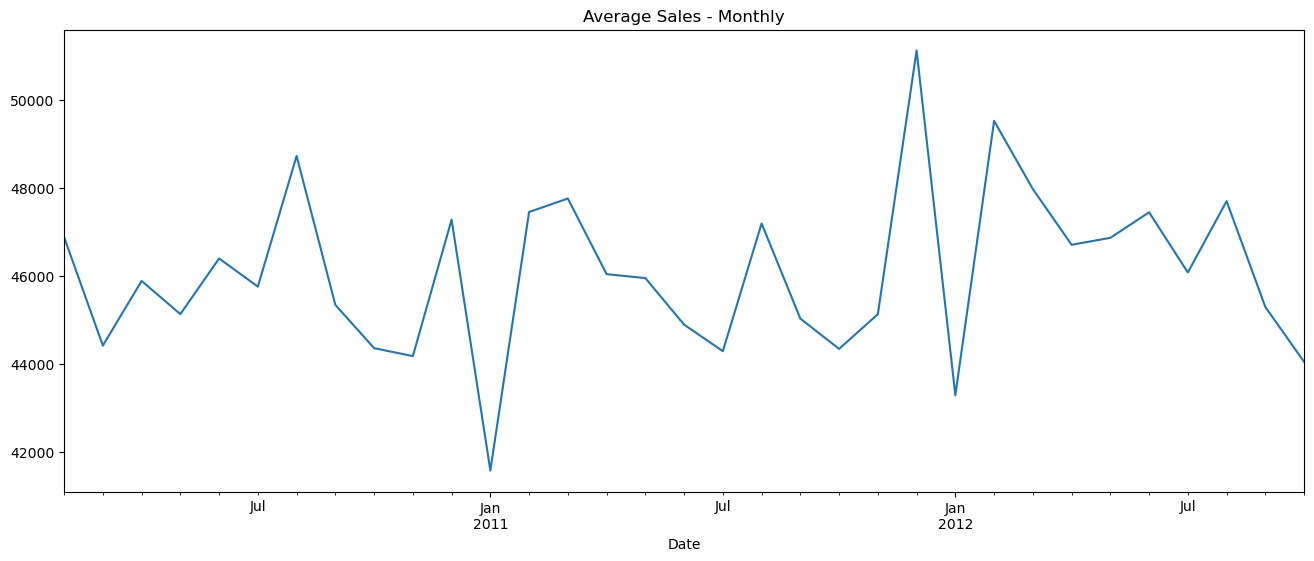

In [162]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

In [163]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

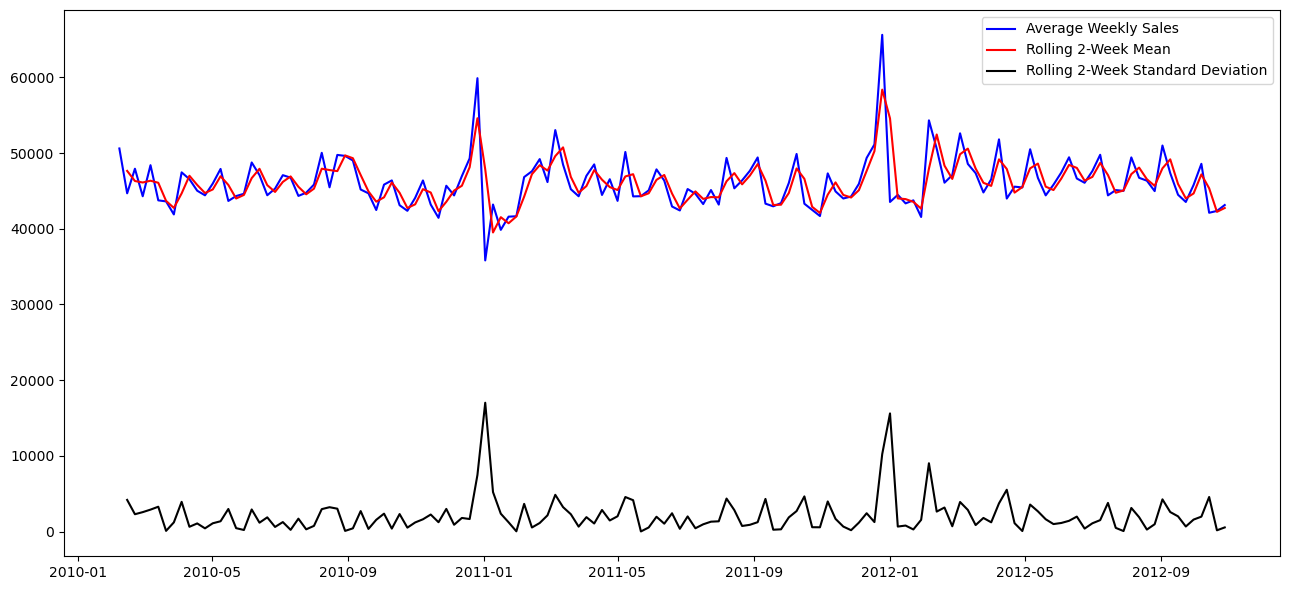

In [164]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

In [165]:
adfuller(df_week['Weekly_Sales'])

(-5.8140187793082925,
 4.3346460273169563e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2456.3123084781137)

In [166]:
train_data = df_week[:int(0.7*(len(df_week)))] 
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 14)
Test: (43, 14)


In [167]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

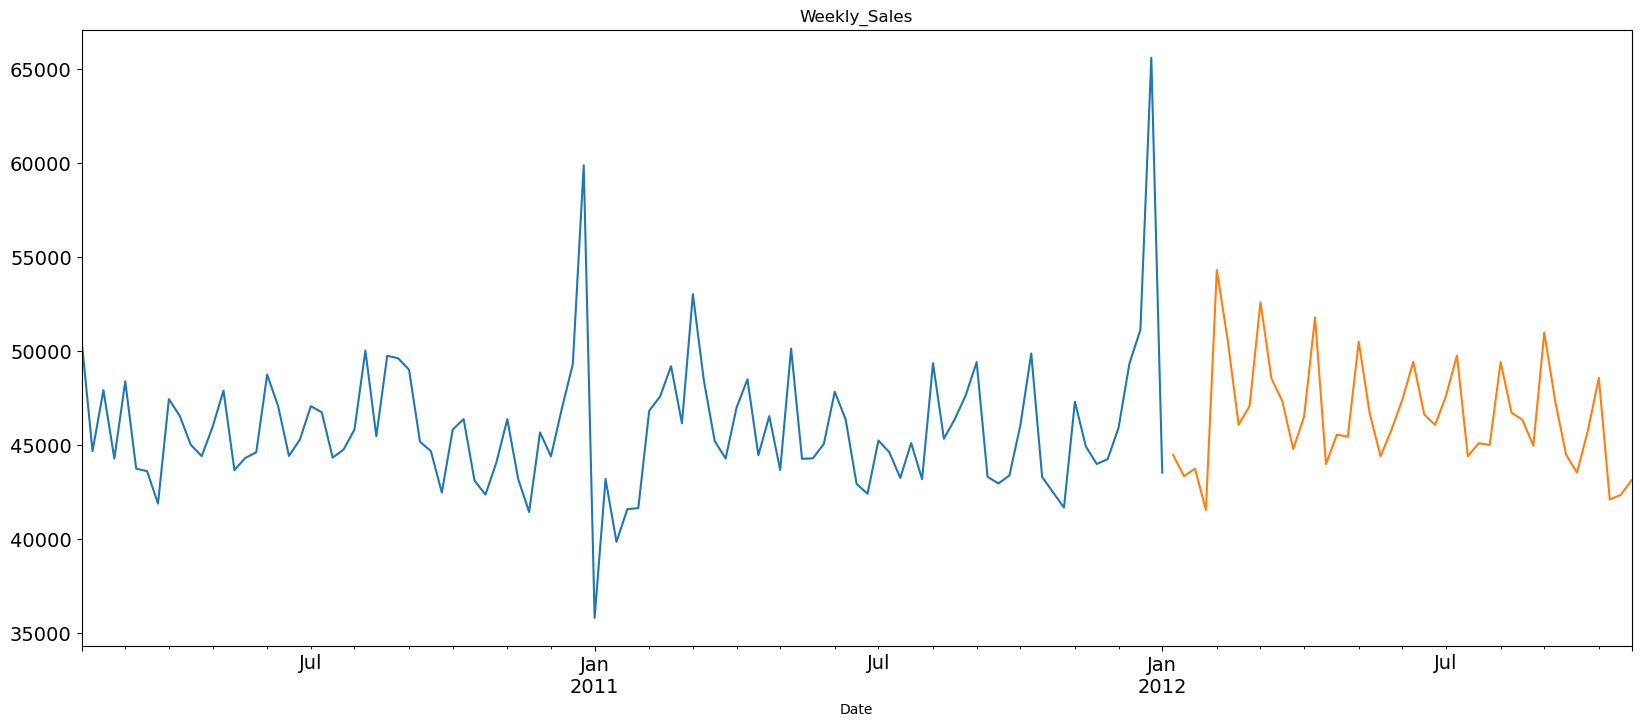

In [168]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

# Decomposing Weekly Data to Observe Seasonality

In [169]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data 

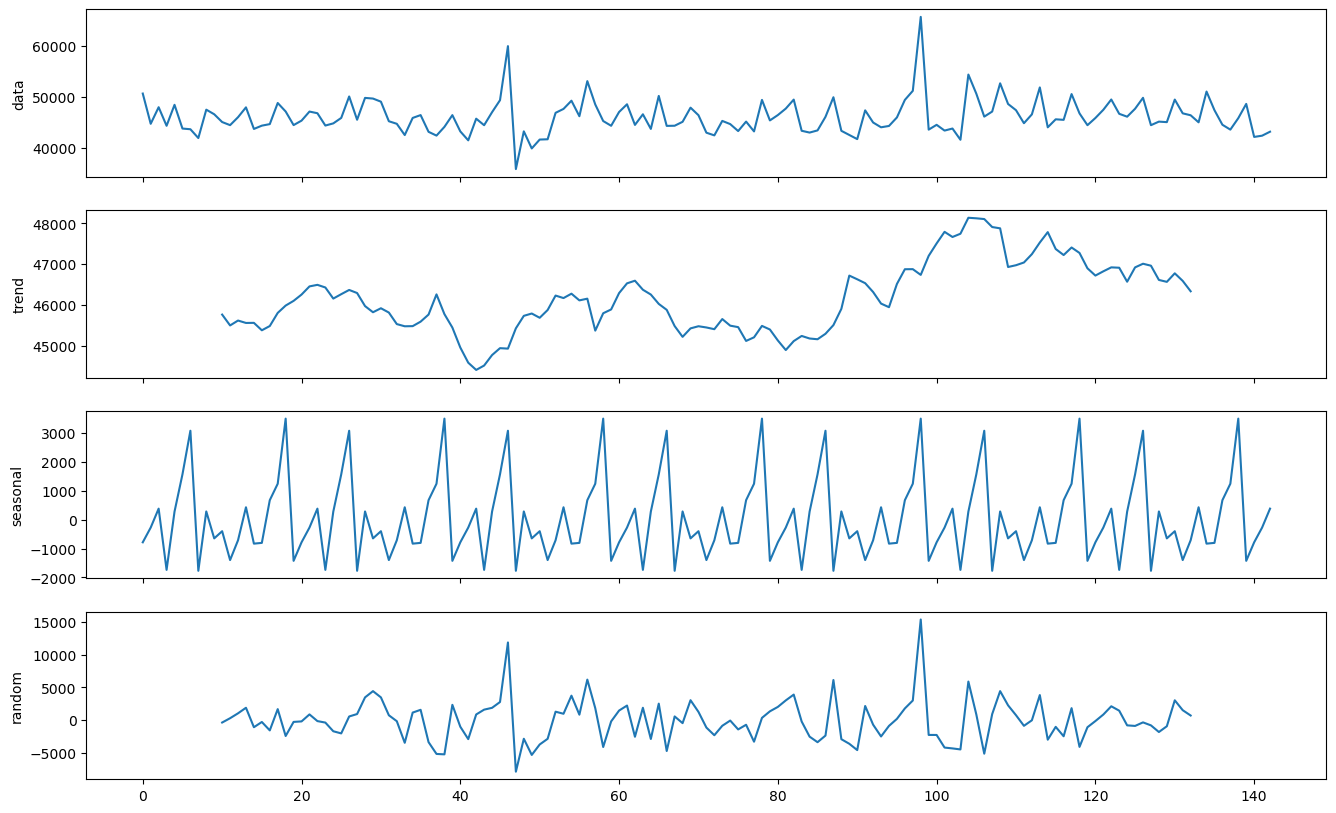

In [170]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

* * * * *

Looking at the graphs, we can see a **pattern repeating every 20 steps**, always returning to its starting point. This repeating pattern is really helpful for fine-tuning my model.

# Trying To Make Data More Stationary

Now, I will try to make my data more stationary. To do this, I will try model with differenced, logged and shifted data.

## 1. Difference

In [171]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values

In [172]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

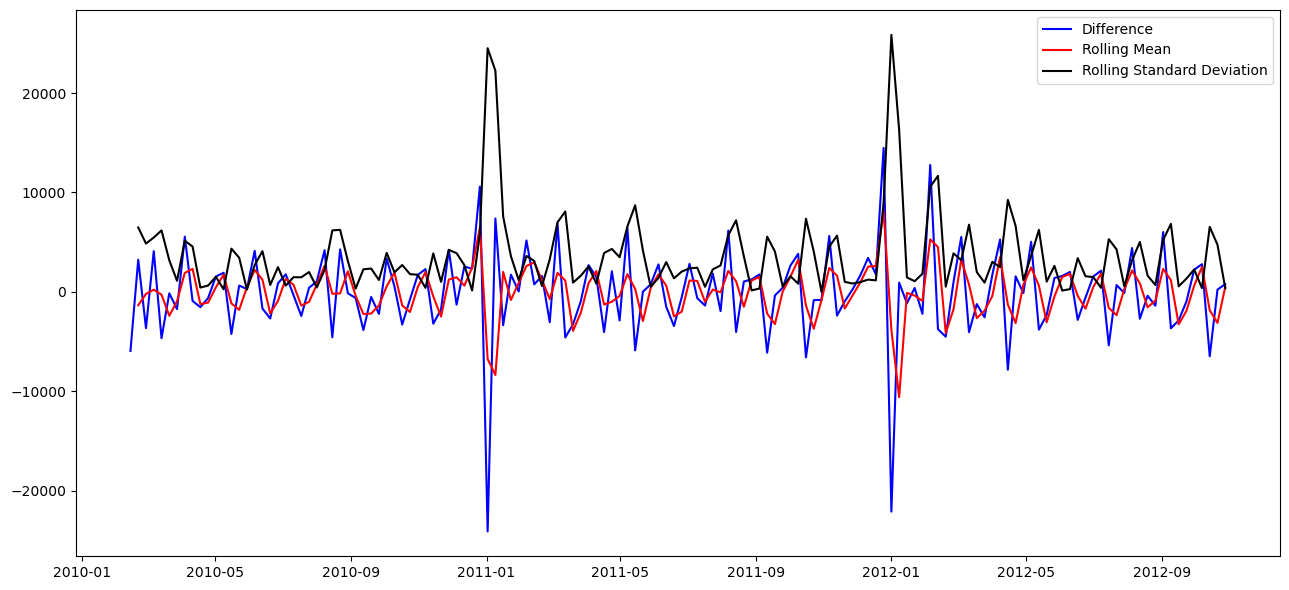

In [173]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 2.Shift

In [174]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data 

In [175]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean() 
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

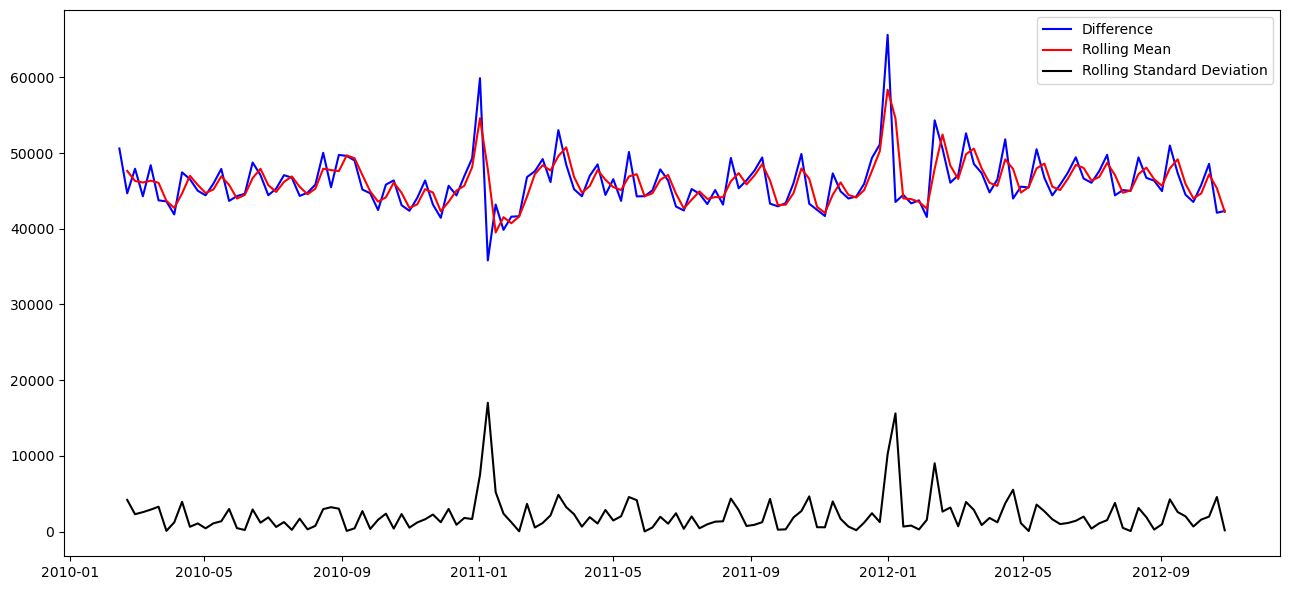

In [176]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 3.Log

In [177]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data

In [178]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

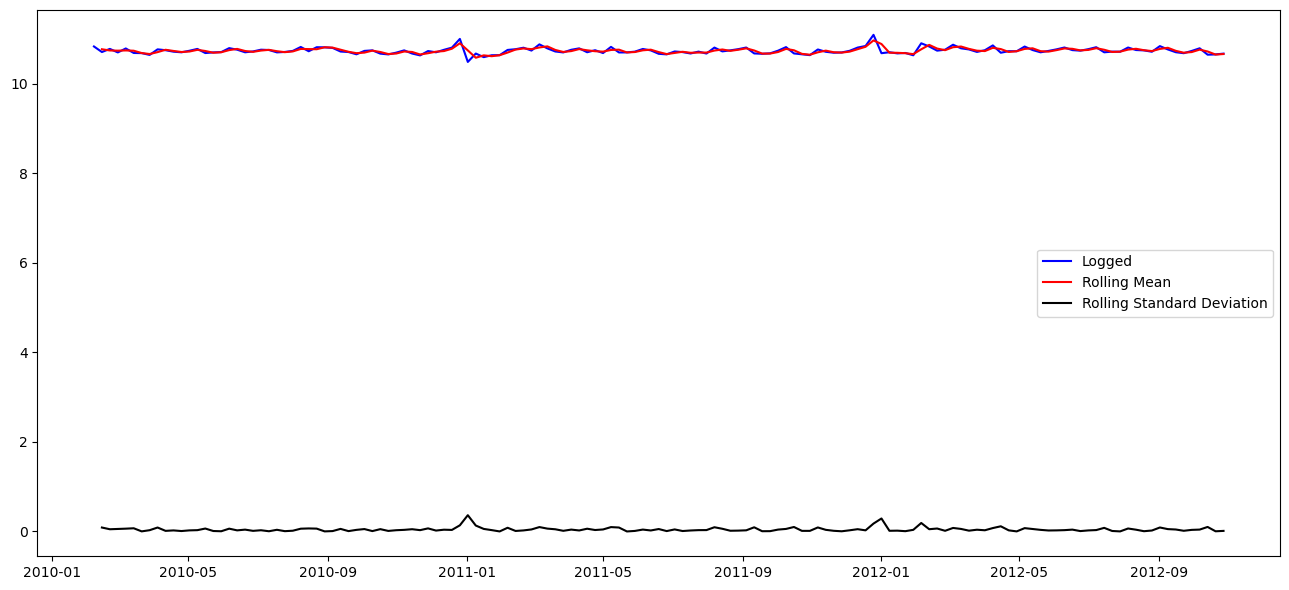

In [179]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

# Auto-ARIMA MODEL

In [182]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [183]:
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1964.073, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1936.544, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1936.045, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1926.354, Time=0.04 sec
 ARI

ARIMA(maxiter=200, order=(3, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

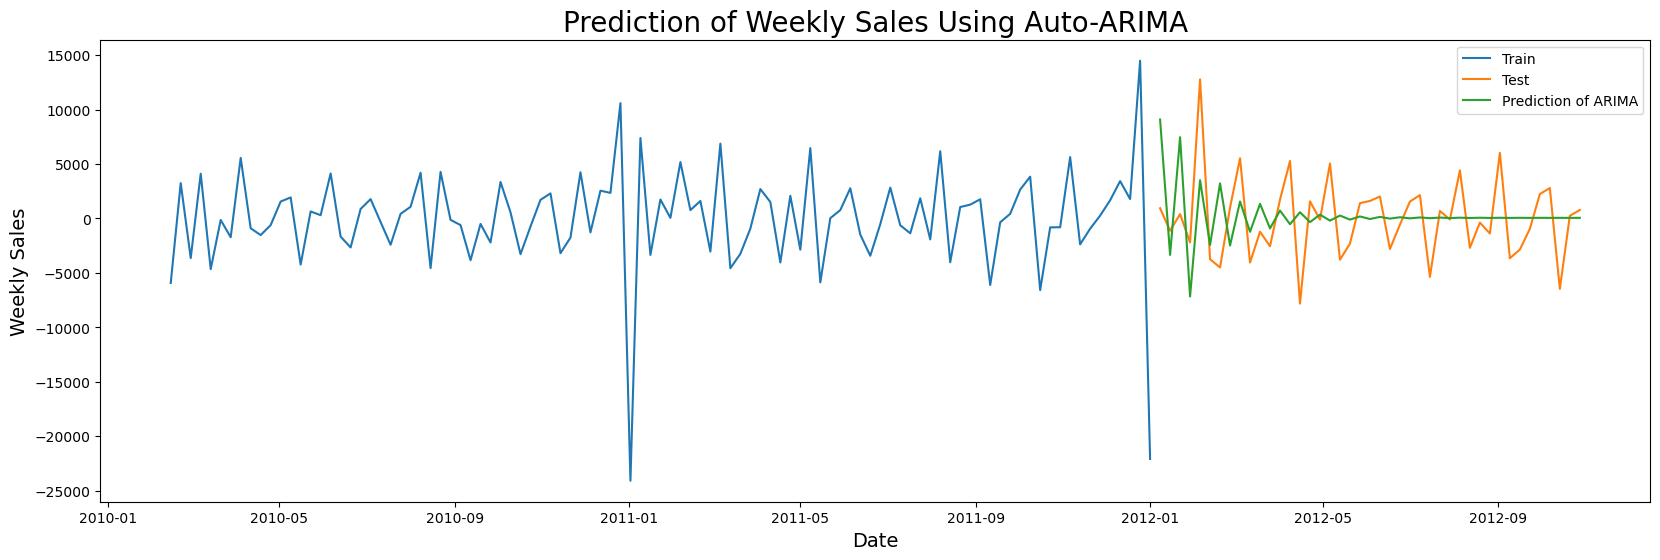

In [184]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

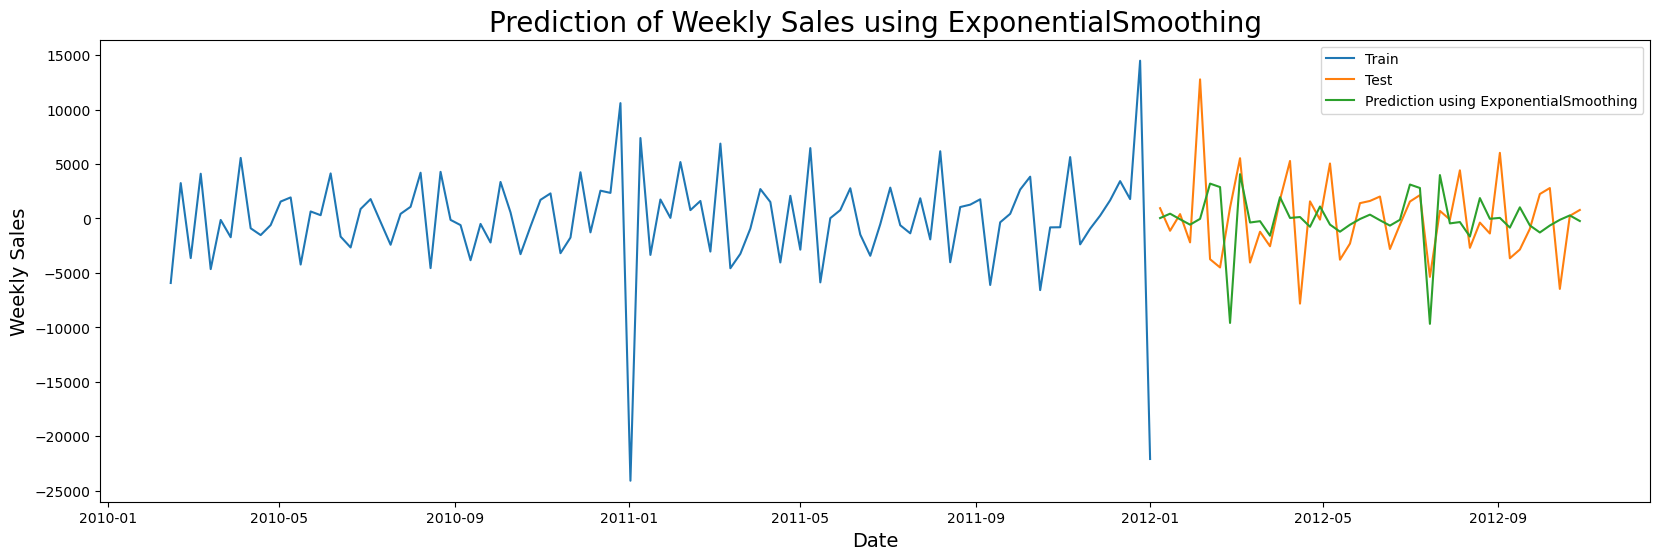

In [185]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [186]:
wmae_test(test_data_diff, y_pred)

3324.7621530893643